In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import re
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from rich import print
from tqdm import tqdm

In [2]:
def read_file_to_str_li(fp, print_exp=True):
    with open(fp, "r") as f:
        lines = f.read().split("\n")
    if print_exp:
        print(f"Read from {fp}:")
        print(f"First line: {lines[0]} | Last line: {lines[-1]}")
        print("-" * 6)

    return lines


# define the function blocks
def convert_to_int(input_str):
    if input_str == "" or input_str == " ":
        return None
    return int(input_str)


def convert_to_str(input_str):
    return str(input_str)


# map the inputs to the function blocks
converts = {
    "i": convert_to_int,
    "s": convert_to_str,
}


def convert_str_li_to_other_li(
    str_li, pattern="i", per_letter=False, sep=" ", start_row=0, end_row=None
):
    """ Convert a list of string to a list of other types
    
    pattern: a list of types for one item. 
        'i' for int, 's' for string
        'si' means: convert the 1st item to string, the rest to integer
        If separated items are more than pattern items,
        use the last one from the parttern.
    if per_letter=True, ignore sep and separate item per letter
    """
    target_str_li = str_li[start_row:end_row]
    # find max item num
    max_item_num = 1
    if per_letter:
        max_item_num = max([len(s) for s in target_str_li])
    else:
        max_item_num = max([len(s.split(sep)) for s in target_str_li])

    # extend the pattern to the max itme num
    pattern = (
        pattern + f"{pattern[-1]}" * (max_item_num - len(pattern))
        if max_item_num > len(pattern)
        else pattern
    )

    # convert
    if per_letter:
        return [
            [converts[pattern[idx]](item) for idx, item in enumerate(s)]
            for s in target_str_li
        ]
    else:
        if sep == " ":
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split())]
                for s in target_str_li
            ]
        else:
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split(sep))]
                for s in target_str_li
            ]

In [3]:
fp = "input.txt"
lines = read_file_to_str_li(fp)

print("Convert to:")

# head = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=False, sep=",", start_row=0, end_row=1
# )

# print(f"Head:\n{head}")

data = convert_str_li_to_other_li(
    lines, pattern="i", per_letter=True, sep=" ", start_row=None, end_row=None
)

# data = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=False, sep=" | ", start_row=None, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=False, sep=",", start_row=None, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=False, sep=" -> ", start_row=None, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=False, sep=" ", start_row=2, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="si", per_letter=False, sep=" ", start_row=0, end_row=None
# )
# data = convert_str_li_to_other_li(
#     lines, pattern="i", per_letter=True, sep=" ", start_row=0, end_row=None
# )

print(f"First line: {data[0]}")
print(f"Last line: {data[-1]}")
print("-" * 6)

Read from input.txt:

First line: 1326253315 | Last line: 4824541522

------

Convert to:

First line: [1, 3, 2, 6, 2, 5, 3, 3, 1, 5]

Last line: [4, 8, 2, 4, 5, 4, 1, 5, 2, 2]

------

In [4]:
def add_step(old_arr):
    new_pad = np.pad(old_arr, pad_width=1, constant_values=-1) + 1

    total_flash_mask = new_pad >= 10
    new_flash_mask = np.copy(total_flash_mask)

    while np.sum(new_flash_mask) > 0:
        down = np.roll(new_flash_mask, 1, axis=0).astype("int")
        up = np.roll(new_flash_mask, -1, axis=0).astype("int")
        right = np.roll(new_flash_mask, 1, axis=1).astype("int")
        left = np.roll(new_flash_mask, -1, axis=1).astype("int")
        up_left = np.roll(up, -1, axis=1)
        up_right = np.roll(up, 1, axis=1)
        down_left = np.roll(down, -1, axis=1)
        down_right = np.roll(down, 1, axis=1)

        new_pad += (
            down + up + right + left + up_left + up_right + down_left + down_right
        )

        new_flash_mask = (new_pad >= 10) & (~total_flash_mask)
        total_flash_mask = new_pad >= 10

    new_pad = np.where(total_flash_mask, 0, new_pad)
    new_arr = new_pad[1:-1, 1:-1]
    flash_num = np.sum(total_flash_mask)
    return new_arr, flash_num, total_flash_mask[1:-1, 1:-1]


oct_arr = np.array(data)

step = 100
count_flash = 0
count = 0
save_flash = []
save_title = []
while True:
    count += 1
    new_oct_arr, new_flash, flash_mask = add_step(oct_arr)
    count_flash += new_flash
    oct_arr = new_oct_arr
    save_flash.append(flash_mask)
    save_title.append(f"Step {count} (light #: {new_flash})")
    if count == 100:
        print(f"Answer to Q1: {count_flash}")
    if new_flash == oct_arr.size:
        print(f"Answer to Q2: {count}")
        break

Answer to Q1: 1749

Answer to Q2: 285

In [5]:
from scipy.signal import convolve

adj_kernal = np.ones((3, 3)).astype("int")
adj_kernal[1, 1] = 0


def add_step(oct_arr):
    oct_arr += 1
    total_flash_mask = oct_arr >= 10
    new_flash_mask = np.copy(total_flash_mask)

    while np.sum(new_flash_mask) > 0:
        oct_arr += convolve(new_flash_mask, adj_kernal, mode="same")
        new_flash_mask = (oct_arr >= 10) & (~total_flash_mask)
        total_flash_mask = oct_arr >= 10

    oct_arr = np.where(total_flash_mask, 0, oct_arr)
    flash_num = np.sum(total_flash_mask)
    return oct_arr, flash_num, total_flash_mask


oct_arr = np.array(data)

step = 100
count_flash = 0
count = 0
save_flash = []
save_title = []
while True:
    count += 1
    new_oct_arr, new_flash, flash_mask = add_step(oct_arr)
    count_flash += new_flash
    oct_arr = new_oct_arr
    save_flash.append(flash_mask)
    save_title.append(f"Step {count} (light #: {new_flash})")
    if count == 100:
        print(f"Answer to Q1: {count_flash}")
    if new_flash == oct_arr.size:
        print(f"Answer to Q2: {count}")
        break

Answer to Q1: 1749

Answer to Q2: 285

In [6]:
import matplotlib.pyplot as plt


def show_light(low_map_pad, title):
    plt.imshow(low_map_pad.astype("int"), interpolation="none")
    plt.axis("off")
    plt.title(title)
    plt.show()

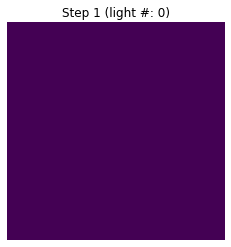

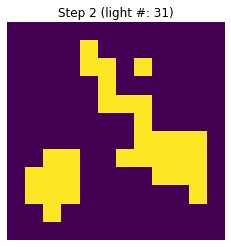

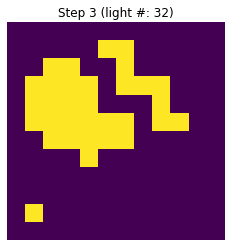

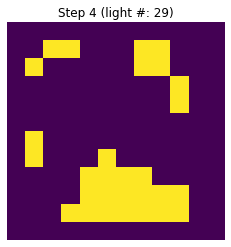

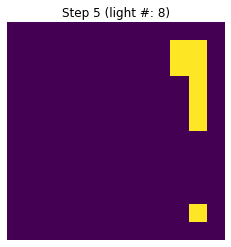

In [7]:
for i in range(5):
    show_light(np.pad(save_flash[i],pad_width=1, constant_values=0), save_title[i])

In [8]:
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Image
from matplotlib import animation, rc

In [10]:
# equivalent to rcParams['animation.html'] = 'html5'
rc("animation", html="html5")

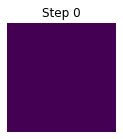

In [11]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.set_title("Step 0")
img = ax.imshow(save_flash[0], interpolation="none")

In [12]:
# initialization function: plot the background of each frame
def init():
    ax.imshow(np.pad(np.zeros_like(save_flash[0]),pad_width=1, constant_values=0), interpolation="none")
    return [img]

In [13]:
# animation function. This is called sequentially
def animate(i):
    show_img = min(len(save_flash) - 1, i)
    ax.imshow(np.pad(save_flash[show_img],pad_width=1, constant_values=0), interpolation="none")
    ax.set_title(f"Step {show_img+1}")
    return [img]

In [14]:
# call the animator. blit=True means only re-draw the parts that
# have changed.
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=range(0, len(save_flash) + 50, 5),
    interval=20,
    blit=True,
)

In [15]:
writergif = animation.PillowWriter(fps=30)
anim.save("animation.gif", writer=writergif)

In [16]:
Image(url="animation.gif")